In [1]:
import numpy as np
import matplotlib.pyplot as plt



In [2]:
#Measurements in mm and degree
Setup_Base = 90.05
Setup_Base_Sigma = 1e-3

Setup_Height = 22.17
Setup_Height_Sigma = 1e-3

Ball_Diameter = {'big': 15.00, 'medium': 12.67, 'little': 10.00}
Ball_Diameter_Sigma ={'big': 1e-3, 'medium': 1e-3, 'little': 1e-3}

Rail_Spacing = 6.06
Rail_Spacing_Sigma = 1e-3

Setup_Angle = np.array([13.79,14.09])
Setup_Angle_Sigma = 1e-2

Gate_Spacing = [16.35, 34.05, 52.18, 71.21, 88.75] # entry 1 is the higest placed gate
Gate_Spacing_Sigma = [1e-3, 1e-3, 1e-3, 1e-3, 1e-3] # entry 1 is the higest placed gate

In [30]:
def read_csv(filename, trim):
    """Read CSV from Waveforms"""
    dat = np.genfromtxt(filename, delimiter=',', skip_header=13, names=True)
    trimdat = dat[trim:]
    time = trimdat['Time_s']
    voltage = trimdat['Channel_1_V']
    return time, voltage



Text(0, 0.5, 'Voltage (V)')

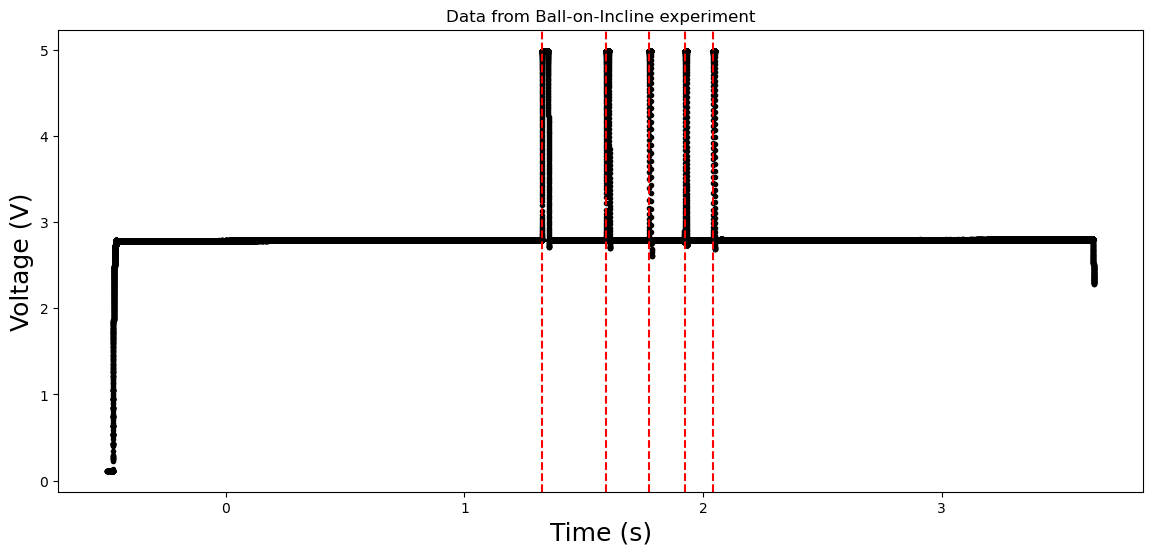

In [62]:
def find_midpoints(time, voltage):
    """Find timing of ball crossings"""
    threshold = np.mean(voltage)+ np.std(voltage)
    Transient_Mask = (voltage[:-1] < threshold) & (voltage[1:] >= threshold)
    Transient_Times = np.array(time[1:])[Transient_Mask]
    return Transient_Times, np.mean(np.diff(time))

filename = 'Waveforms_data/Big_1.csv'
# Read the data and plot it (possibly with passing times in):

trim = 200
time, voltage = read_csv(filename, trim)

timepass, time_Sigma = find_midpoints(time, voltage)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(time, voltage, 'k.', label='Measurements')
#adding a vertical line at each time the ball passes
for t in timepass:
    ax.axvline(t, color='r', linestyle='--', label='Ball pass' if t == timepass[0] else "")
ax.set_title("Data from Ball-on-Incline experiment")
ax.set_xlabel("Time (s)", fontsize=18)
ax.set_ylabel("Voltage (V)", fontsize=18)


## Pendul eksperiment

In [5]:
Pendulum_Height_from_floor = 67.45 #cm
top =58.95# cm
start = 56 #cm
Pendulum_height = top-start

Pendulum_Period = []
Time = []

